In [ ]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import rasterio as rio
import owslib.wcs as wcs

from pathlib import Path
from src.functions import *
import matplotlib.pyplot as plt
from shutil import rmtree
from rasterio.enums import Resampling

This example shows how to process NDVI, get yearly cloud-free index mosaics and derive some stats from it. Functions needed for processing are defined in `src.functions`. 

## Getting example data from WCS

First step is to get the raw data, which is available and described [here](https://ckan.ymparisto.fi/dataset/sentinel-2-image-index-mosaics-s2ind-sentinel-2-kuvamosaiikit-s2ind). 

In [ ]:
ndindex = 'ndvi'
outpath = 'example_data'
ix_path = Path(f'{outpath}/{ndindex}')
os.makedirs(ix_path, exist_ok=True)
datapath = ix_path/'raw'

Georeferenced data can be downloaded from WCS, using `owslib.wcs`.

In [ ]:
wcs_url = 'https://data.nsdc.fmi.fi/geoserver/wcs'
layer = f'PTA:s2m_{ndindex}'
years = [2016,2017,2018,2019,2020,2021,2022]
for y in years: os.makedirs(datapath/str(y), exist_ok=True)

w = wcs.WebCoverageService(wcs_url, version='1.0.0')
c = w[layer]
t = sorted(c.timepositions)
t = [ts for ts in t if '15' not in ts]
t = [ts for ts in t if '2023' not in ts]

The example area is between Kuivaniemi and Ranua, southern Lapland.

In [ ]:
min_x = 457325
min_y = 7702545
size_x = 3000
size_y = 3000
bounds = (min_x, min_y, min_x+10*size_x, min_y+10*size_y)

`t` contains all timepositions that cover a full month. Get the data and save it on the disk.

In [ ]:
for ts in t:
    outfn = f'{ts.split("T")[0][:-2].replace("-","")}.tif'
    img = w.getCoverage(layer,
                crs='EPSG:3067',
                bbox=bounds, 
                WIDTH=size_x,
                HEIGHT=size_y,
                format='GeoTIFF',
                time=[ts])
    out = open(datapath/ts[:4]/outfn, 'wb')
    out.write(img.read())
    out.close()

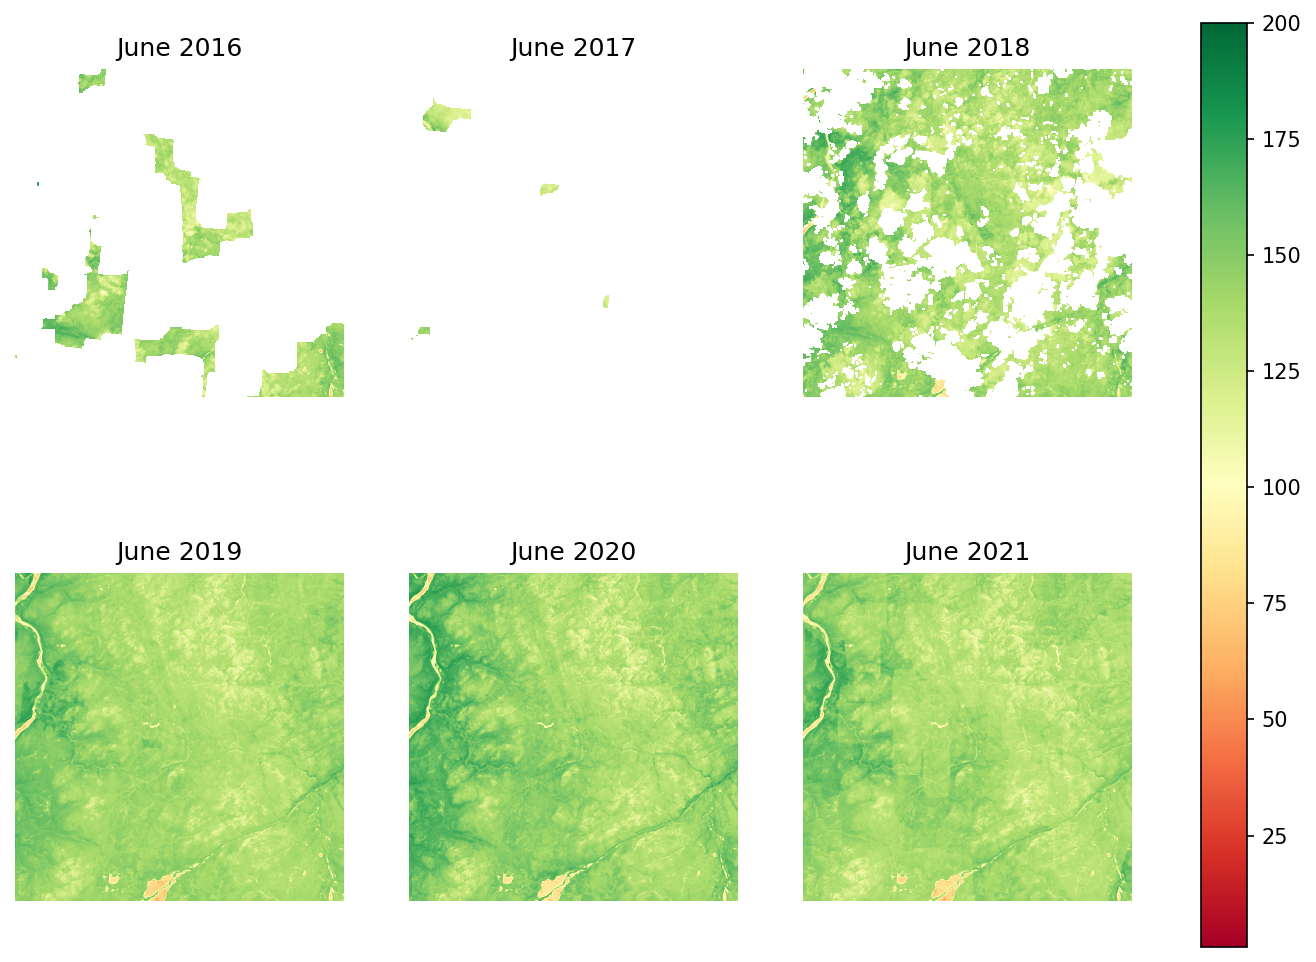

In [ ]:
fig, axs = plt.subplots(2,3, figsize=(12,8), dpi=150)

for a in axs.flatten(): a.axis('off')
    
for a, year in zip(axs.flatten(), years[:-1]):
    with rio.open(datapath/str(year)/f'{year}06.tif') as src:
        im = src.read(masked=True)[0]
    i = a.imshow(im, cmap='RdYlGn', vmin=1, vmax=200)
    a.set_title(f'June {year}')
fig.colorbar(i, ax=axs.ravel().tolist())
plt.show()

# Creating gapless mosaics

## Making base mosaics spring and autumn, and all non-growth seasons

Seasonal base mosaics are used to fill gaps for April, May and October, as they are usually the most cloudy months. Base mosaics are constructed from the median values of April, May and October during the full observation period. 

First specify the timesteps for spring and autumn. Spring is April and May, autumn is mid-September to October.

In [ ]:
spring_tsteps = sorted([t for t in c.timepositions if 
                        any(mon in t for mon in ('04-30', '05-15', '05-31'))])

autumn_tsteps = sorted([t for t in c.timepositions if 
                        any(mon in t for mon in ('10-15', '10-31'))])

Download the files from WCS.

In [ ]:
os.makedirs(ix_path/'basedata_spring', exist_ok=True)

for ts in spring_tsteps:
    outfn = f'{ts.split("T")[0].replace("-","")}.tif'
    img = w.getCoverage(layer,
                crs='EPSG:3067',
                bbox=bounds, 
                WIDTH=size_x,
                HEIGHT=size_y,
               format='GeoTIFF',
                time=[ts])
    out = open(ix_path/'basedata_spring'/outfn, 'wb')
    out.write(img.read())
    out.close()

Read files as masked arrays, get median and save as `base_spring.tif`.

In [ ]:
spring_files = os.listdir(ix_path/'basedata_spring')
spring_vals = []
for f in spring_files:
    with rio.open(ix_path/'basedata_spring'/f) as src:
        spring_vals.append(src.read(masked=True)[0])
        prof = src.profile
        
spring_vals = np.ma.array(spring_vals)
spring_base = np.ma.median(spring_vals, axis=0)
with rio.open(ix_path/'base_spring.tif', 'w', **prof) as dest:
    dest.write(spring_base,1)

Remove the files not needed anymore.

In [ ]:
rmtree(ix_path/'basedata_spring')

Do the same for autumn.

In [ ]:
os.makedirs(ix_path/'basedata_autumn', exist_ok=True)

for ts in autumn_tsteps:
    outfn = f'{ts.split("T")[0][:-2].replace("-","")}.tif'
    img = w.getCoverage(layer,
                crs='EPSG:3067',
                bbox=bounds, 
                WIDTH=size_x,
                HEIGHT=size_y,
                format='GeoTIFF',
                time=[ts])
    out = open(ix_path/'basedata_autumn'/outfn, 'wb')
    out.write(img.read())
    out.close()

autumn_files = os.listdir(ix_path/'basedata_autumn')
autumn_vals = []
for f in autumn_files:
    with rio.open(ix_path/'basedata_autumn'/f) as src:
        autumn_vals.append(src.read(masked=True)[0])
        prof = src.profile

autumn_vals = np.ma.array(autumn_vals)
autumn_base = np.ma.median(autumn_vals, axis=0)
        
with rio.open(ix_path/'base_autumn.tif', 'w', **prof) as dest:
    dest.write(autumn_base,1)
rmtree(ix_path/'basedata_autumn')

Generate combined base mosaic, used to derive yearly amplitude.

In [ ]:
vals = np.ma.array(np.ma.concatenate([spring_vals, autumn_vals]))
with rio.open(ix_path/'base_all.tif', 'w', **prof) as dest:
    dest.write(np.ma.median(vals, axis=0), 1)

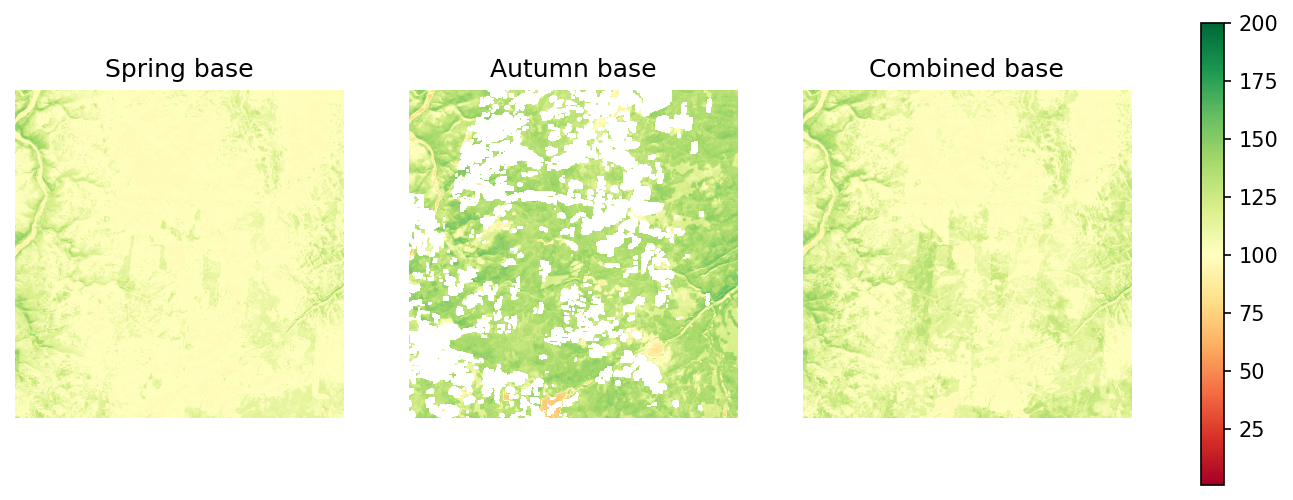

In [ ]:
fig, axs = plt.subplots(1,3, figsize=(12,4), dpi=150)
for a in axs: a.axis('off')
    
with rio.open(ix_path/'base_spring.tif') as src:
    im = src.read(masked=True)[0]
axs[0].imshow(im, cmap='RdYlGn', vmin=1, vmax=200)
axs[0].set_title('Spring base')
with rio.open(ix_path/'base_autumn.tif') as src:
    im = src.read(masked=True)[0]
axs[1].imshow(im, cmap='RdYlGn', vmin=1, vmax=200)
axs[1].set_title('Autumn base')
with rio.open(ix_path/'base_all.tif') as src:
    im = src.read(masked=True)[0]
i = axs[2].imshow(im, cmap='RdYlGn', vmin=1, vmax=200)
axs[2].set_title('Combined base')
fig.colorbar(i, ax=axs.ravel().tolist())
plt.show()

Now that all data needed for further processing is ready, let's start creating cloudless mosaics.

## Fill gaps with the maximum value of previous two years

As this step needs two previous years of data, the earliest year that can be processed from Sentinel-2 data is 2018. Also, because at the time of writing there is not enough data to process 2022, it is also omitted.

First step is to use `fill_prev_years` to fill gaps with the maximum value of previous two years.

In [ ]:
fillyears = [2018,2019,2020,2021,2022]
filled_path = ix_path/f'interp'
os.makedirs(filled_path, exist_ok=True)
for f in fillyears: os.makedirs(filled_path/str(f), exist_ok=True)
fill_prev_years(datapath, filled_path, fillyears)

As an example, see how May images look at this point.

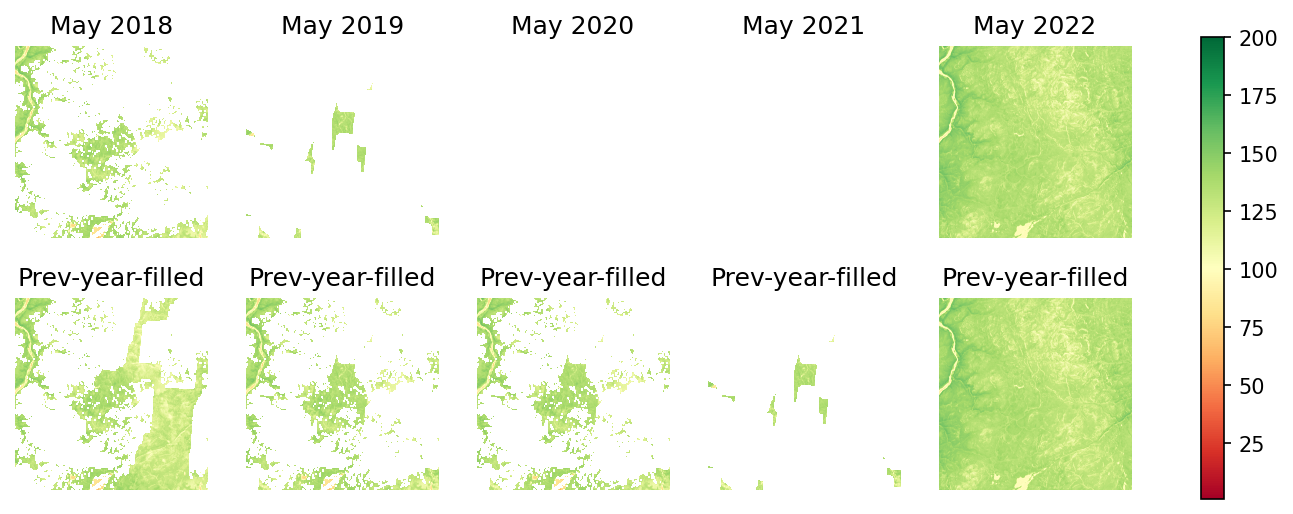

In [ ]:
fig, axs = plt.subplots(2,5, figsize=(12,4), dpi=150)

for a in axs.flatten(): a.axis('off')
    
for i, year in zip(range(5), fillyears):
    with rio.open(datapath/str(year)/f'{year}05.tif') as src:
        im = src.read(masked=True)[0]
    axim = axs[0,i].imshow(im, cmap='RdYlGn', vmin=1, vmax=200)
    axs[0,i].set_title(f'May {year}')
    
for i, year in zip(range(5), fillyears):
    with rio.open(filled_path/str(year)/f'{year}05.tif') as src:
        im = src.read(masked=True)[0]
    axim = axs[1,i].imshow(im, cmap='RdYlGn', vmin=1, vmax=200)
    axs[1,i].set_title('Prev-year-filled')
fig.colorbar(axim, ax=axs.ravel().tolist())
plt.show()

Same for October

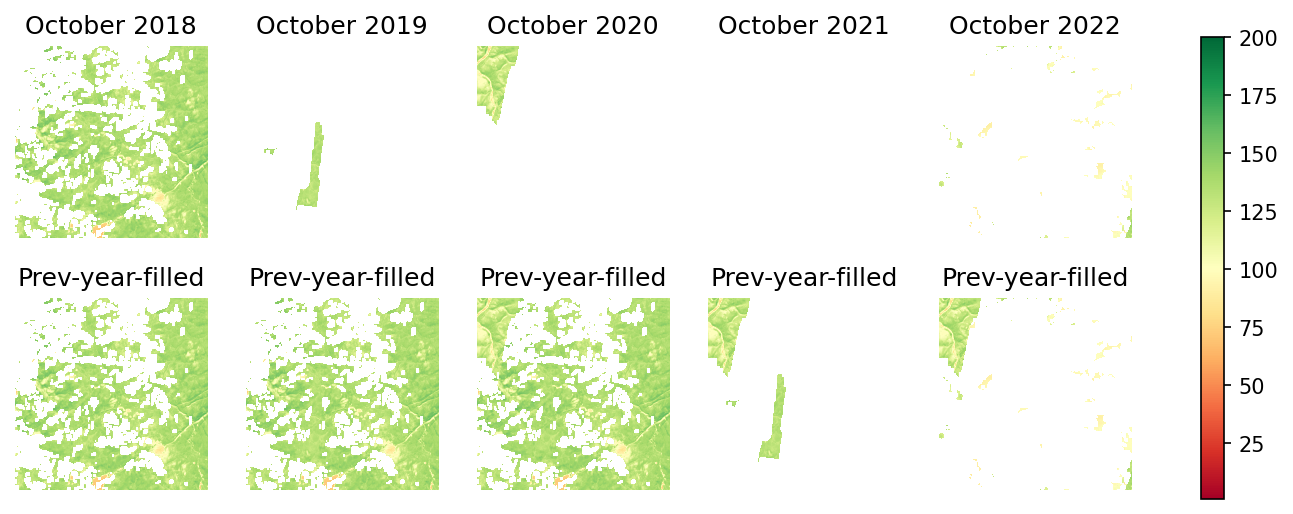

In [ ]:
fig, axs = plt.subplots(2,5, figsize=(12,4), dpi=150)

for a in axs.flatten(): a.axis('off')
    
for i, year in zip(range(5), fillyears):
    with rio.open(datapath/str(year)/f'{year}10.tif') as src:
        im = src.read(masked=True)[0]
    axim = axs[0,i].imshow(im, cmap='RdYlGn', vmin=1, vmax=200)
    axs[0,i].set_title(f'October {year}')
    
for i, year in zip(range(5), fillyears):
    with rio.open(filled_path/str(year)/f'{year}10.tif') as src:
        im = src.read(masked=True)[0]
    axim = axs[1,i].imshow(im, cmap='RdYlGn', vmin=1, vmax=200)
    axs[1,i].set_title('Prev-year-filled')
fig.colorbar(axim, ax=axs.ravel().tolist())
plt.show()

## Run `rasterio.fill.fillnodata`

Run `rasterio.fill.fillnodata` for the mosaics, in order to interpolate possible missing values. This usually doesn't fill that much aside from small holes. `fill_nodata` runs `rasterio.fill.fillnodata` to all images. Here we also clip the data between 0 and 200, as `rasterio.fill.fillnodata` sometimes interpolates data incorrectly.

In [ ]:
fill_nodata(filled_path)

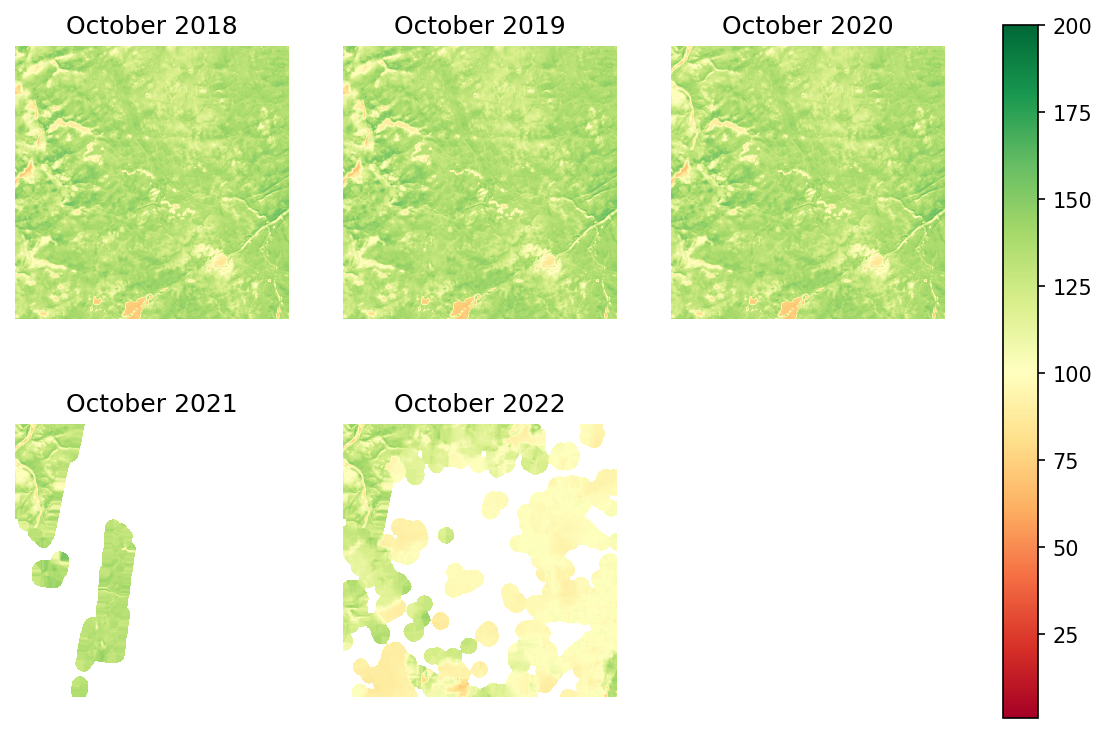

In [ ]:
fig, axs = plt.subplots(2,3, figsize=(10,6), dpi=150)

for a in axs.flatten(): a.axis('off')
    
for a, year in zip(axs.flatten(), fillyears):
    with rio.open(filled_path/str(year)/f'{year}10.tif') as src:
        im = src.read(masked=True)[0]
    i = a.imshow(im, cmap='RdYlGn', vmin=1, vmax=200)
    a.set_title(f'October {year}')
fig.colorbar(i, ax=axs.ravel().tolist())
plt.show()

## Fill April and May with spring mosaic

Use base mosaic to fill missing data with `fill_base`. Pictures below show the difference before and after filling.

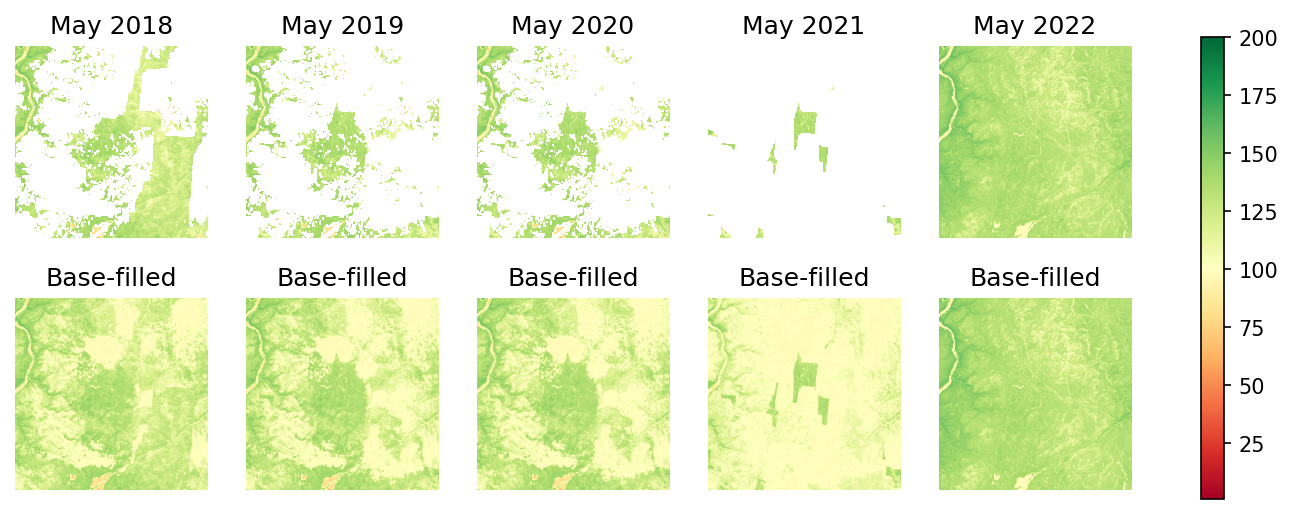

In [ ]:
fig, axs = plt.subplots(2,5, figsize=(12,4), dpi=150)

for a in axs.flatten(): a.axis('off')
    
for i, year in zip(range(5), fillyears):
    with rio.open(filled_path/str(year)/f'{year}05.tif') as src:
        im = src.read(masked=True)[0]
    axim = axs[0,i].imshow(im, cmap='RdYlGn', vmin=1, vmax=200)
    axs[0,i].set_title(f'May {year}')
    
fill_base(filled_path, ix_path/'base_spring.tif')
for i, year in zip(range(5), fillyears):
    with rio.open(filled_path/str(year)/f'{year}05.tif') as src:
        im = src.read(masked=True)[0]
    axim = axs[1,i].imshow(im, cmap='RdYlGn', vmin=1, vmax=200)
    axs[1,i].set_title('Base-filled')
fig.colorbar(axim, ax=axs.ravel().tolist())
plt.show()

## Fill October with autumn mosaic

Same thing as before, but for October.

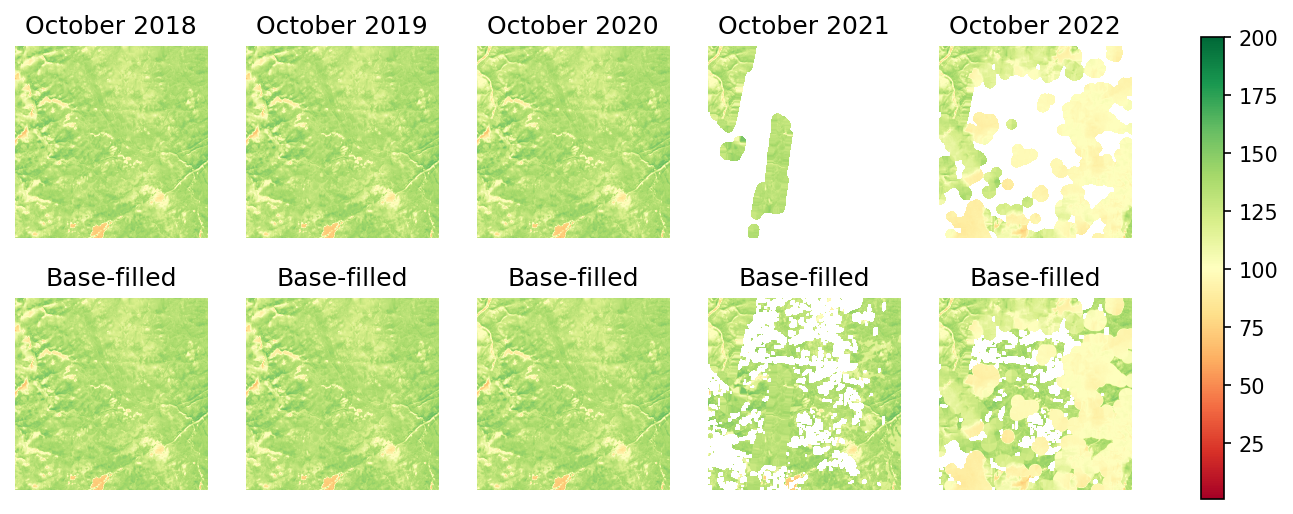

In [ ]:
fig, axs = plt.subplots(2,5, figsize=(12,4), dpi=150)

for a in axs.flatten(): a.axis('off')
    
for i, year in zip(range(5), fillyears):
    with rio.open(filled_path/str(year)/f'{year}10.tif') as src:
        im = src.read(masked=True)[0]
    axim = axs[0,i].imshow(im, cmap='RdYlGn', vmin=1, vmax=200)
    axs[0,i].set_title(f'October {year}')
    
fill_base(filled_path, ix_path/'base_autumn.tif')

for i, year in zip(range(5), fillyears):
    
    with rio.open(filled_path/str(year)/f'{year}10.tif') as src:
        im = src.read(masked=True)[0]
    axim = axs[1,i].imshow(im, cmap='RdYlGn', vmin=1, vmax=200)
    axs[1,i].set_title(f'Base-filled')
fig.colorbar(axim, ax=axs.ravel().tolist())
plt.show()

## Fill August with mean value of July and September

There are some areas where August has gaps, and they are filled with `fill_august`. 

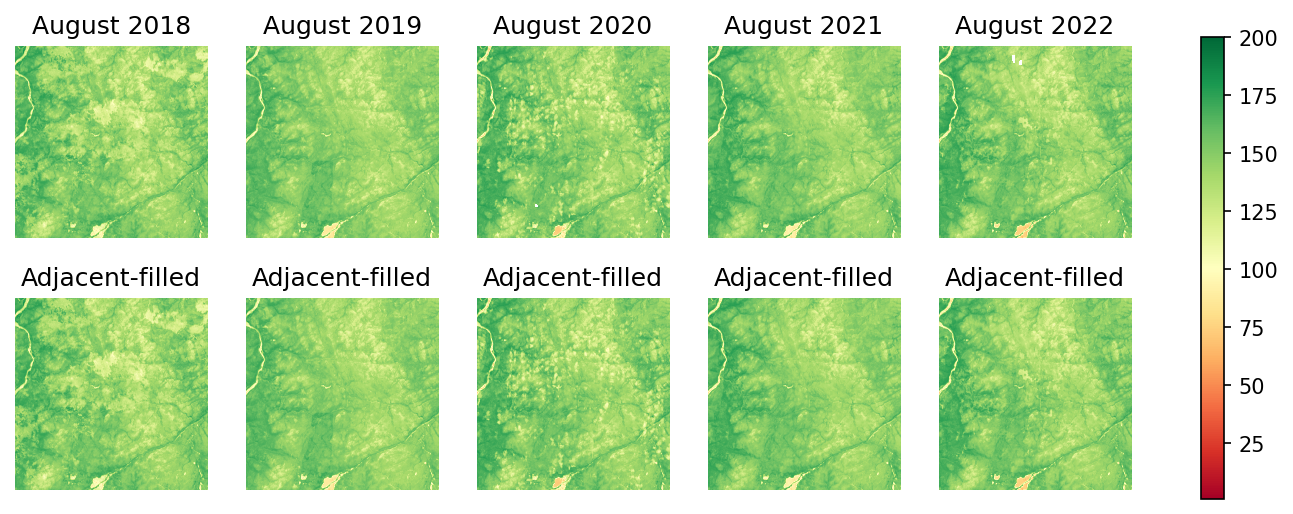

In [ ]:
fig, axs = plt.subplots(2,5, figsize=(12,4), dpi=150)

for a in axs.flatten(): a.axis('off')
    
for i, year in zip(range(5), fillyears):
    with rio.open(filled_path/str(year)/f'{year}08.tif') as src:
        im = src.read(masked=True)[0]
    axim = axs[0,i].imshow(im, cmap='RdYlGn', vmin=1, vmax=200)
    axs[0,i].set_title(f'August {year}')
    
fill_august(filled_path)

for i, year in zip(range(5), fillyears):
    
    with rio.open(filled_path/str(year)/f'{year}08.tif') as src:
        im = src.read(masked=True)[0]
    axim = axs[1,i].imshow(im, cmap='RdYlGn', vmin=1, vmax=200)
    axs[1,i].set_title(f'Adjacent-filled')
fig.colorbar(axim, ax=axs.ravel().tolist())
plt.show()

# Collating statistics for years

After getting all the gapless data ready, running `make_stats` creates the yearly statistics for NDVI.

In [ ]:
statspath = ix_path/'stats'
os.makedirs(statspath, exist_ok=True)
make_stats(filled_path, statspath, ix_path/'base_all.tif')

## Yearly maximum

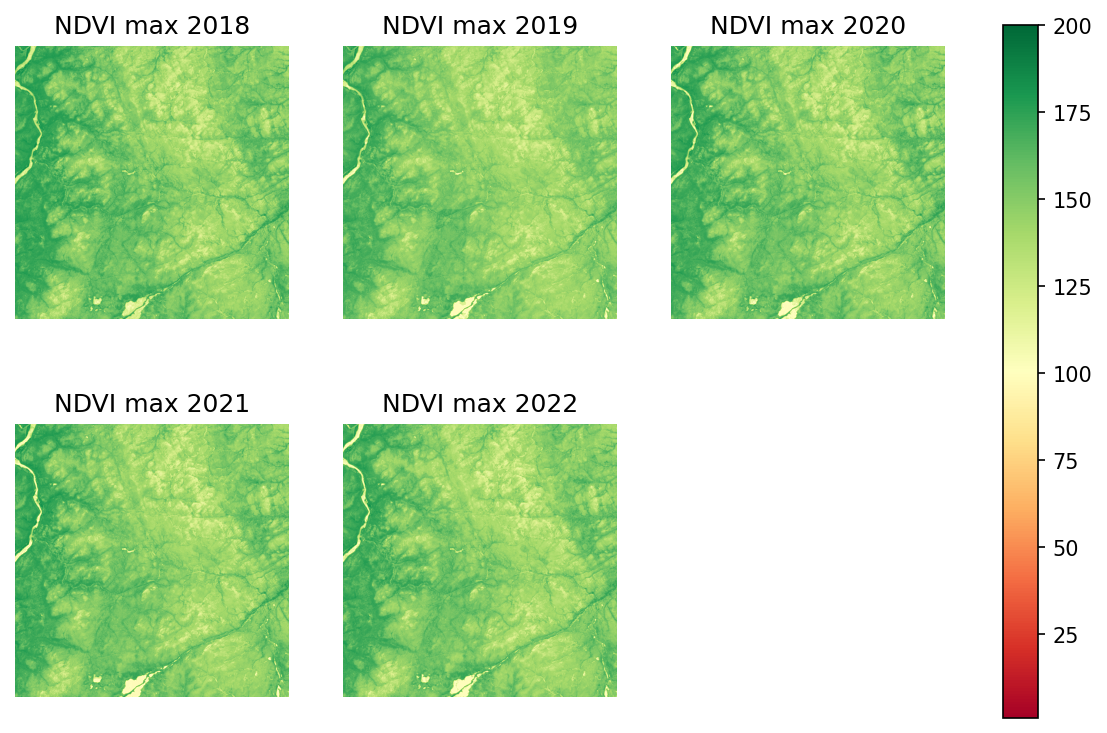

In [ ]:
fig, axs = plt.subplots(2,3, figsize=(10,6), dpi=150)

for a in axs.flatten(): a.axis('off')

for a, year in zip(axs.flatten(), fillyears):
    with rio.open(statspath/str(year)/f'max.tif') as src:
        im = src.read(masked=True)[0]
    i = a.imshow(im, cmap='RdYlGn', vmin=1, vmax=200)
    a.set_title(f'NDVI max {year}')
fig.colorbar(i, ax=axs.ravel().tolist())
plt.show()

## Yearly minimum

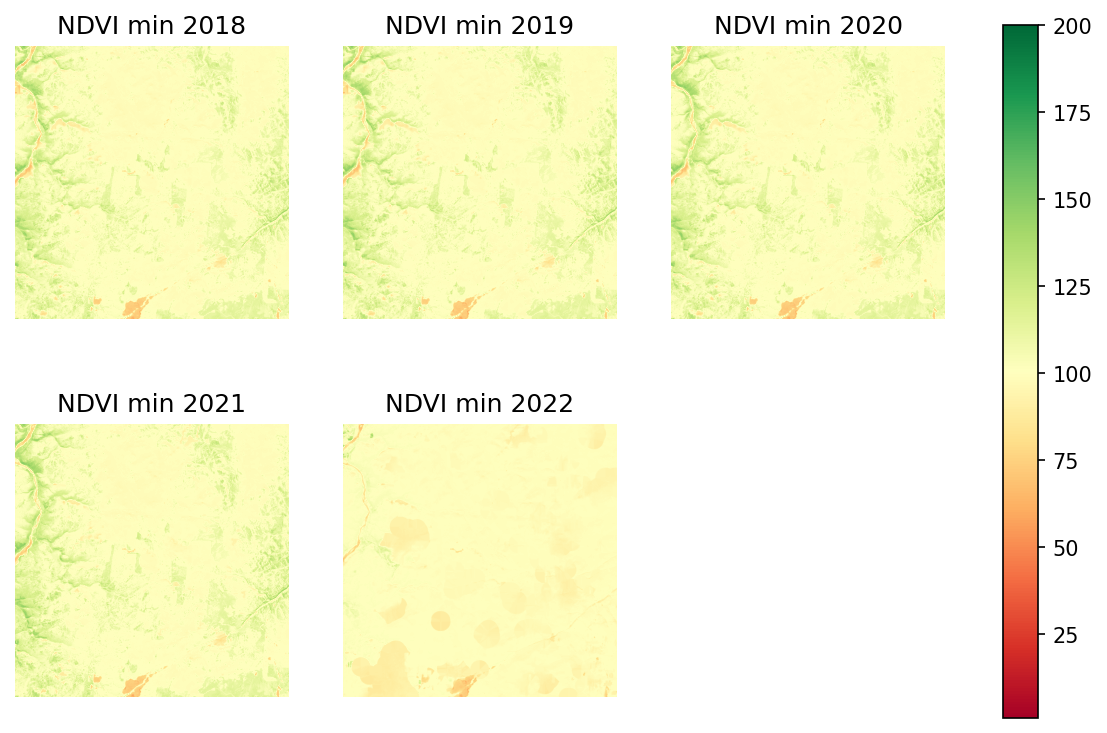

In [ ]:
fig, axs = plt.subplots(2,3, figsize=(10,6), dpi=150)

for a in axs.flatten(): a.axis('off')

for a, year in zip(axs.flatten(), fillyears):
    with rio.open(statspath/str(year)/f'min.tif') as src:
        im = src.read(masked=True)[0]
    i = a.imshow(im, cmap='RdYlGn', vmin=1, vmax=200)
    a.set_title(f'NDVI min {year}')
fig.colorbar(i, ax=axs.ravel().tolist())
plt.show()

## Yearly mean

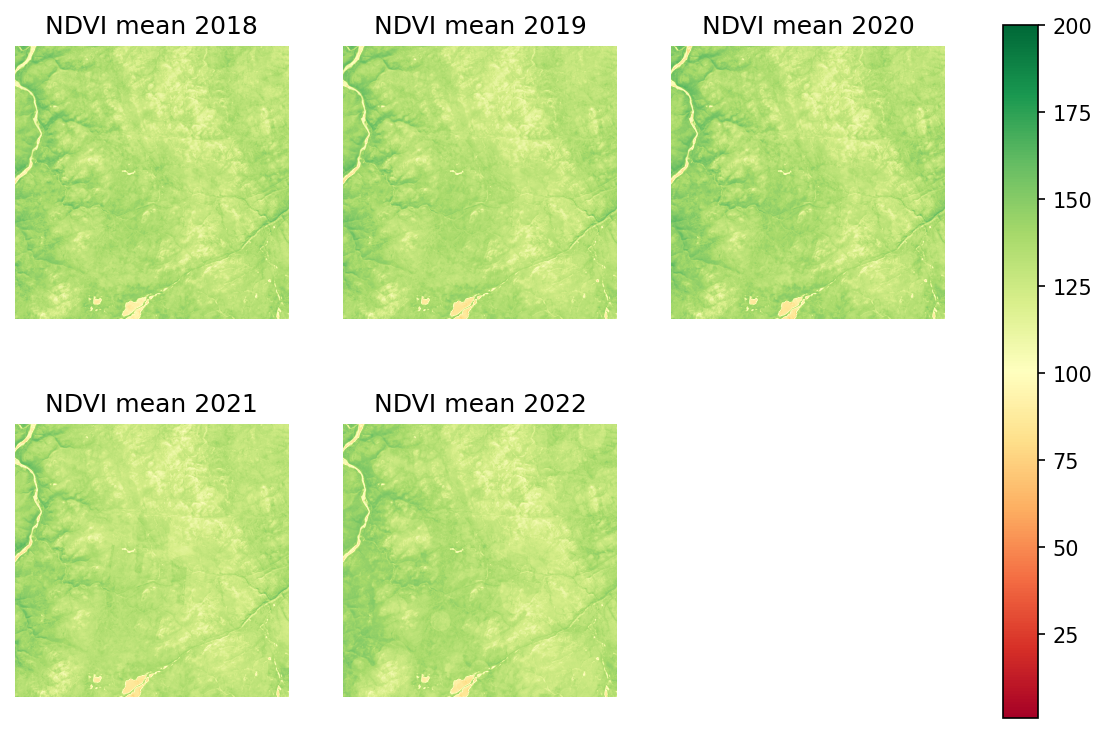

In [ ]:
fig, axs = plt.subplots(2,3, figsize=(10,6), dpi=150)

for a in axs.flatten(): a.axis('off')

for a, year in zip(axs.flatten(), fillyears):
    with rio.open(statspath/str(year)/f'mean.tif') as src:
        im = src.read(masked=True)[0]
    i = a.imshow(im, cmap='RdYlGn', vmin=1, vmax=200)
    a.set_title(f'NDVI mean {year}')
fig.colorbar(i, ax=axs.ravel().tolist())
plt.show()

## Yearly median

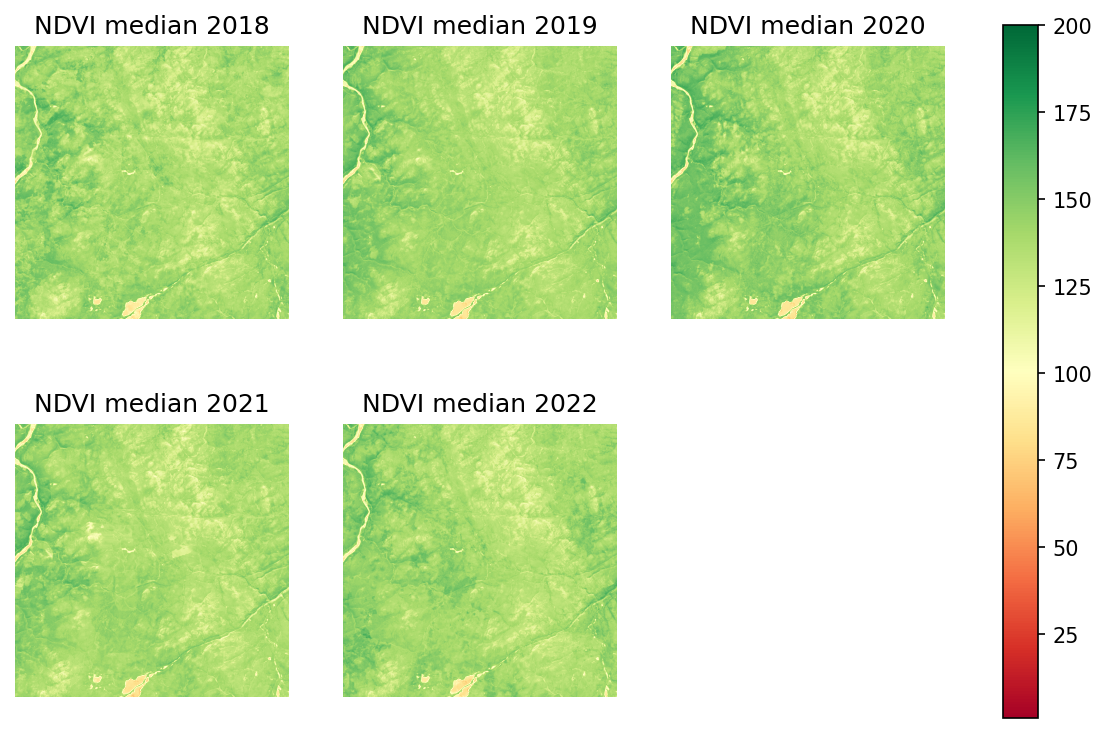

In [ ]:
fig, axs = plt.subplots(2,3, figsize=(10,6), dpi=150)

for a in axs.flatten(): a.axis('off')

for a, year in zip(axs.flatten(), fillyears):
    with rio.open(statspath/str(year)/f'median.tif') as src:
        im = src.read(masked=True)[0]
    i = a.imshow(im, cmap='RdYlGn', vmin=1, vmax=200)
    a.set_title(f'NDVI median {year}')
fig.colorbar(i, ax=axs.ravel().tolist())
plt.show()

## Yearly sum

Sum can be used as a proxy for productivity for the areas, especially for fields etc.

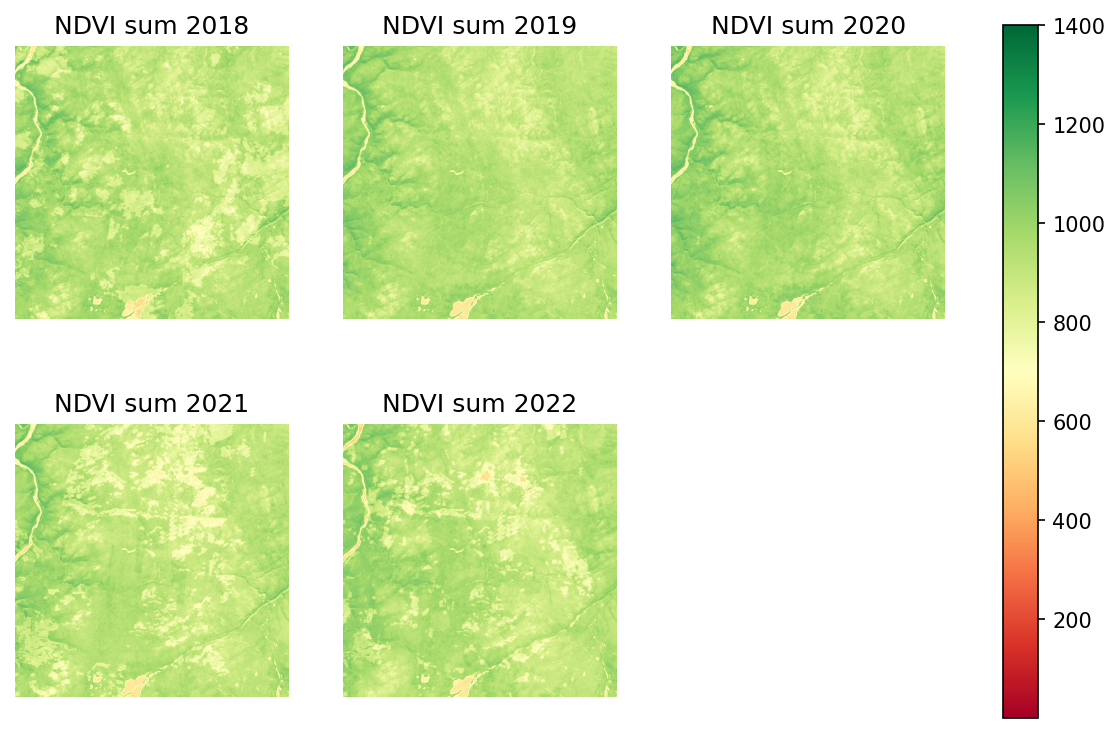

In [ ]:
fig, axs = plt.subplots(2,3, figsize=(10,6), dpi=150)

for a in axs.flatten(): a.axis('off')

for a, year in zip(axs.flatten(), fillyears):
    with rio.open(statspath/str(year)/f'sum.tif') as src:
        im = src.read(masked=True)[0]
    i = a.imshow(im, cmap='RdYlGn', vmin=1, vmax=1400)
    a.set_title(f'NDVI sum {year}')
fig.colorbar(i, ax=axs.ravel().tolist())
plt.show()

## Yearly amplitude

Amplitude is calculated as $amp = max - base\_all$, and used for phenology applications.

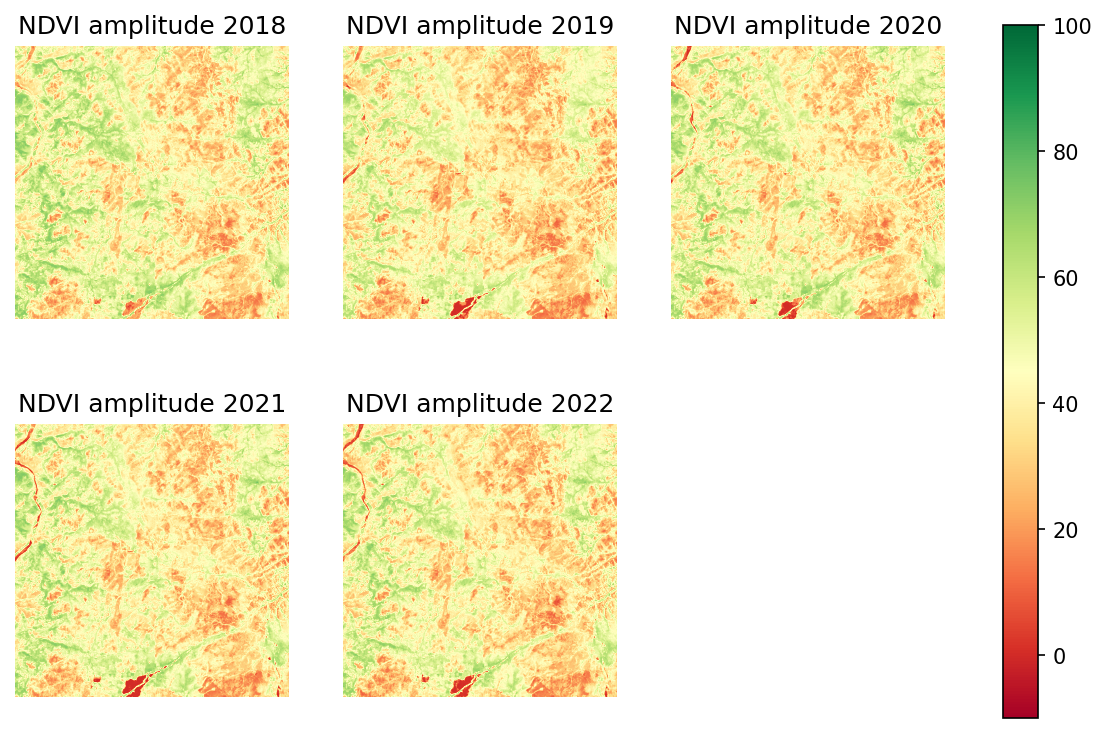

In [ ]:
fig, axs = plt.subplots(2,3, figsize=(10,6), dpi=150)

for a in axs.flatten(): a.axis('off')

for a, year in zip(axs.flatten(), fillyears):
    with rio.open(statspath/str(year)/f'amp.tif') as src:
        im = src.read(masked=False)[0]
    i = a.imshow(im, cmap='RdYlGn', vmin=-10, vmax=100)
    a.set_title(f'NDVI amplitude {year}')
fig.colorbar(i, ax=axs.ravel().tolist())
plt.show()

Comparison with previous amplitude formula $max - median$.

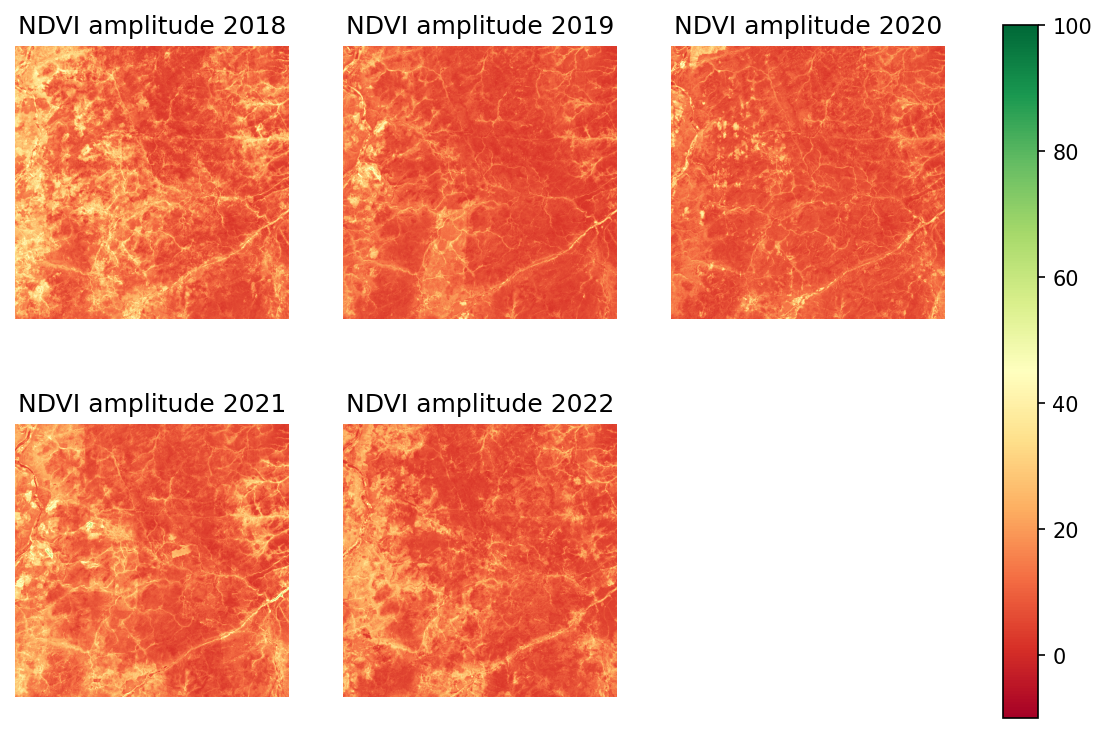

In [ ]:
fig, axs = plt.subplots(2,3, figsize=(10,6), dpi=150)

for a in axs.flatten(): a.axis('off')

for a, year in zip(axs.flatten(), fillyears):
    with rio.open(statspath/str(year)/'max.tif') as src:
        maxvals = src.read(masked=True)[0]
    with rio.open(statspath/str(year)/'median.tif') as src:
        medians = src.read(masked=True)[0]
    amp = (maxvals - medians)
    i = a.imshow(amp, cmap='RdYlGn', vmin=-10, vmax=100)
    a.set_title(f'NDVI amplitude {year}')
fig.colorbar(i, ax=axs.ravel().tolist())
plt.show()

# Post-processing

As a post-processing step, the mosaics are clipped with the borders of Finland, and overviews are built for faster rendering. This are doesn't need to be clipped but let's build overviews. `src.functions.clip_rasters` can be used to clip data with some polygon.

In [ ]:
base_fns = [ix_path/'base_spring.tif', ix_path/'base_autumn.tif'] 
stats_fns = [statspath/year/f for year in os.listdir(statspath) for f in os.listdir(statspath/year)]
interp_fns = [filled_path/year/f for year in os.listdir(filled_path) for f in os.listdir(filled_path/year)]

factors = [2**(n+1) for n in range(4)] # Images are so small that this is enough

for f in base_fns + stats_fns + interp_fns:
    dst = rio.open(f, 'r+')
    dst.build_overviews(factors, Resampling.nearest)
    dst.update_tags(ns='rio_overview', resampling='nearest')
    dst.close()